[*********************100%%**********************]  1 of 1 completed


Vasicek Model:
   MAE: 1.589164
   RMSE: 1.933880

CIR Model:
   MAE: 0.920455
   RMSE: 1.276309


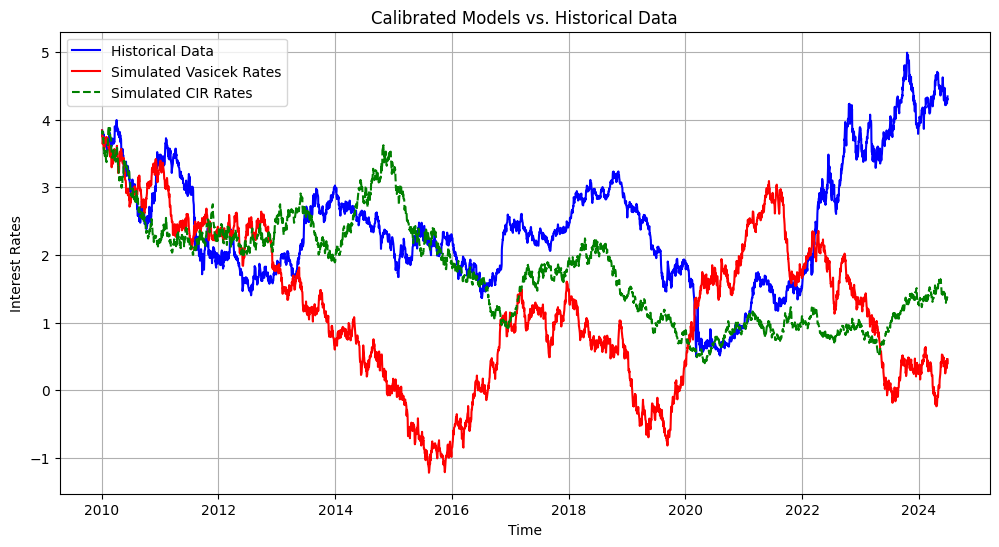

In [13]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
import yfinance as yf
import matplotlib.pyplot as plt

class InterestRateModel:
    def __init__(self, r0, alpha, b, sigma):
        self.r0 = r0
        self.alpha = alpha
        self.b = b
        self.sigma = sigma

    def simulate(self, T, dt, model_type='vasicek'):
        n = int(T / dt)
        rates = np.zeros(n)
        rates[0] = self.r0
        for i in range(1, n):
            if model_type == 'vasicek':
                dr = self.alpha * (self.b - rates[i-1]) * dt + self.sigma * np.sqrt(dt) * np.random.normal()
            elif model_type == 'cir':
                dr = self.alpha * (self.b - rates[i-1]) * dt + self.sigma * np.sqrt(max(rates[i-1], 0) * dt) * np.random.normal()
                dr = max(dr, -rates[i-1])  # Ensure non-negative rates
            rates[i] = rates[i-1] + dr
        return rates

def model_loss(params, data, model_type='vasicek'):
    alpha, b, sigma = params
    model = InterestRateModel(data.iloc[0], alpha, b, sigma)
    simulated_data = model.simulate(len(data), 1, model_type)
    error = np.mean((simulated_data - data.values) ** 2)  # MSE
    return error

def fetch_us_treasury_data(start_date, end_date):
    ticker = "^TNX"
    treasury_data = yf.download(ticker, start=start_date, end=end_date)
    return treasury_data['Close']

def calibrate_models(data):
    bounds = [(0.001, 1.0), (0.001, 1.0), (0.001, 1.0)]

    # Differential Evolution for Vasicek
    result_vasicek = differential_evolution(model_loss, bounds, args=(data, 'vasicek'))
    alpha_v, b_v, sigma_v = result_vasicek.x
    model_vasicek = InterestRateModel(data.iloc[0], alpha_v, b_v, sigma_v)
    simulated_rates_vasicek = model_vasicek.simulate(len(data), 1, 'vasicek')
    error_vasicek_mae = np.mean(np.abs(simulated_rates_vasicek - data.values))
    error_vasicek_rmse = np.sqrt(np.mean((simulated_rates_vasicek - data.values) ** 2))

    # Differential Evolution for CIR
    result_cir = differential_evolution(model_loss, bounds, args=(data, 'cir'))
    alpha_c, b_c, sigma_c = result_cir.x
    model_cir = InterestRateModel(data.iloc[0], alpha_c, b_c, sigma_c)
    simulated_rates_cir = model_cir.simulate(len(data), 1, 'cir')
    error_cir_mae = np.mean(np.abs(simulated_rates_cir - data.values))
    error_cir_rmse = np.sqrt(np.mean((simulated_rates_cir - data.values) ** 2))

    return {
        'model_vasicek': model_vasicek,
        'simulated_rates_vasicek': simulated_rates_vasicek,
        'error_vasicek_mae': error_vasicek_mae,
        'error_vasicek_rmse': error_vasicek_rmse,
        'model_cir': model_cir,
        'simulated_rates_cir': simulated_rates_cir,
        'error_cir_mae': error_cir_mae,
        'error_cir_rmse': error_cir_rmse
    }

if __name__ == "__main__":
    start_date = "2010-01-01"
    end_date = "2024-07-01"
    us_treasury_data = fetch_us_treasury_data(start_date, end_date)
    
    results = calibrate_models(us_treasury_data)
    
    print("Vasicek Model:")
    print(f"   MAE: {results['error_vasicek_mae']:.6f}")
    print(f"   RMSE: {results['error_vasicek_rmse']:.6f}")
    print()
    print("CIR Model:")
    print(f"   MAE: {results['error_cir_mae']:.6f}")
    print(f"   RMSE: {results['error_cir_rmse']:.6f}")
    
    plt.figure(figsize=(12, 6))
    plt.plot(us_treasury_data.index, us_treasury_data.values, label='Historical Data', color='blue')
    plt.plot(us_treasury_data.index, results['simulated_rates_vasicek'], label='Simulated Vasicek Rates', color='red', linestyle='-')
    plt.plot(us_treasury_data.index, results['simulated_rates_cir'], label='Simulated CIR Rates', color='green', linestyle='--')
    plt.title('Calibrated Models vs. Historical Data')
    plt.xlabel('Time')
    plt.ylabel('Interest Rates')
    plt.legend()
    plt.grid(True)
    plt.show()
